1. torchvision을 사용하여 CIFAR10의 학습용 데이터, 시험용 데이터 불러오기, 정규화
2. 합성곱 신경망 정의
3. 손실 함수 정의
4. 학습용 데이터를 사용하여 신경망 학습
5. 시험용 데이터를 사용하여 신경망 검사

In [1]:
#결과 inline에 출력
%matplotlib inline

In [2]:
import torch
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import collections
from sklearn import datasets
from imblearn import under_sampling
from typing import Any, Callable, Dict, List, Optional, Tuple
import os
import numpy as np
from torch.nn import functional as F

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
print(torch.cuda.device_count())

2


In [5]:
print(torch.__version__)

1.7.1+cu101


In [6]:
print(torchvision.__version__)

0.8.2+cu101


In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 2048

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers= 8 ,pin_memory= True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8, pin_memory= True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
type(trainset.data)

numpy.ndarray

In [9]:
trainset.data.shape

(50000, 32, 32, 3)

In [10]:
trainset.data[0][0]

array([[ 59,  62,  63],
       [ 43,  46,  45],
       [ 50,  48,  43],
       [ 68,  54,  42],
       [ 98,  73,  52],
       [119,  91,  63],
       [139, 107,  75],
       [145, 110,  80],
       [149, 117,  89],
       [149, 120,  93],
       [131, 103,  77],
       [125,  99,  76],
       [142, 115,  91],
       [144, 112,  86],
       [137, 105,  79],
       [129,  97,  71],
       [137, 106,  79],
       [134, 106,  76],
       [124,  97,  64],
       [139, 113,  78],
       [139, 112,  75],
       [133, 105,  69],
       [136, 105,  74],
       [139, 108,  77],
       [152, 120,  89],
       [163, 131, 100],
       [168, 136, 108],
       [159, 129, 102],
       [158, 130, 104],
       [158, 132, 108],
       [152, 125, 102],
       [148, 124, 103]], dtype=uint8)

In [11]:
type(trainset.targets)

list

In [12]:
print('Original dataset shape %s' % collections.Counter(trainset.targets))


Original dataset shape Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


In [13]:
class unbalance_CIFAR10(CIFAR10):
     def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,
    ) -> None:
        super(unbalance_CIFAR10, self).__init__(root, transform=transform,
                                    target_transform=target_transform)
        

     
        rus = under_sampling.RandomUnderSampler(
            sampling_strategy={
                0: 50,
                1: 5000,
                2: 50,
                3: 5000,
                4: 50,
                5: 5000,
                6: 50,
                7: 5000,
                8: 50,
                9: 5000
                
            },
            random_state=42
        )
        self.data, self.targets = rus.fit_resample(np.array(self.data).reshape(50000,32*32*3), np.array(self.targets))
#         self.data, self.targets = torch.Tensor(self.data.reshape(-1,32,32,3)).to(dtype=torch.uint8), torch.Tensor(self.targets).to(dtype=torch.uint8)
        self.data, self.targets = self.data.reshape(-1,32,32,3), self.targets



In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 2048

trainset = unbalance_CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers= 8 ,pin_memory= True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=8, pin_memory= True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [15]:
print('reshape dataset shape %s' % collections.Counter(trainset.targets.tolist()))

reshape dataset shape Counter({1: 5000, 3: 5000, 5: 5000, 7: 5000, 9: 5000, 0: 50, 2: 50, 4: 50, 6: 50, 8: 50})


In [16]:
type(trainset.data)

numpy.ndarray

In [17]:
type(testset.data)

numpy.ndarray

In [18]:
trainset.data.shape

(25250, 32, 32, 3)

In [19]:
type(trainset.targets)

numpy.ndarray

In [20]:
len(trainset.data)

25250

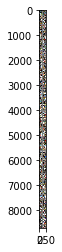

  cat   dog   cat   cat


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
print(dataiter)
images, labels = dataiter.next()
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [22]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
          nn.Conv2d(3, 32, 3),
          nn.ReLU(),
          nn.Conv2d(32, 32, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )

        self.layer2 = torch.nn.Sequential(
          nn.Conv2d(32, 64, 3),
          nn.ReLU(),
          nn.Conv2d(64, 64, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )


        self.fc1 = nn.Linear(1600, 120)
        self.bn1 = nn.BatchNorm1d(120)
        self.bn2 = nn.BatchNorm1d(84)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net()

if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

net.to(device)

DataParallel(
  (module): Net(
    (layer1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (layer2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (fc1): Linear(in_features=1600, out_features=120, bias=True)
    (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_feat

In [23]:
import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [24]:
#torch 를 이용해서 재구성하기, for문을 사용하면 느려질 수 밖에 없음

In [25]:
def custom_CE_tensor(output,labels):
    log_prob = -1.0 * F.log_softmax(output, 1)
    loss = log_prob.gather(1, labels.unsqueeze(1))
    loss = loss.mean()
    return loss

In [26]:
import time
start = time.time()  # 시작 시간 저장

In [27]:
net.train()
for epoch in range(600):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = custom_CE_tensor(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 1.817
[2,    10] loss: 1.235
[3,    10] loss: 1.012
[4,    10] loss: 0.884
[5,    10] loss: 0.787
[6,    10] loss: 0.714
[7,    10] loss: 0.667
[8,    10] loss: 0.621
[9,    10] loss: 0.582
[10,    10] loss: 0.545
[11,    10] loss: 0.517
[12,    10] loss: 0.494
[13,    10] loss: 0.464
[14,    10] loss: 0.442
[15,    10] loss: 0.419
[16,    10] loss: 0.401
[17,    10] loss: 0.369
[18,    10] loss: 0.358
[19,    10] loss: 0.338
[20,    10] loss: 0.318
[21,    10] loss: 0.306
[22,    10] loss: 0.283
[23,    10] loss: 0.274
[24,    10] loss: 0.254
[25,    10] loss: 0.242
[26,    10] loss: 0.234
[27,    10] loss: 0.216
[28,    10] loss: 0.203
[29,    10] loss: 0.192
[30,    10] loss: 0.183
[31,    10] loss: 0.176
[32,    10] loss: 0.162
[33,    10] loss: 0.160
[34,    10] loss: 0.152
[35,    10] loss: 0.148
[36,    10] loss: 0.149
[37,    10] loss: 0.139
[38,    10] loss: 0.134
[39,    10] loss: 0.123
[40,    10] loss: 0.117
[41,    10] loss: 0.117
[42,    10] loss: 0.106
[

[334,    10] loss: 0.015
[335,    10] loss: 0.014
[336,    10] loss: 0.013
[337,    10] loss: 0.014
[338,    10] loss: 0.012
[339,    10] loss: 0.013
[340,    10] loss: 0.013
[341,    10] loss: 0.011
[342,    10] loss: 0.011
[343,    10] loss: 0.011
[344,    10] loss: 0.012
[345,    10] loss: 0.012
[346,    10] loss: 0.014
[347,    10] loss: 0.013
[348,    10] loss: 0.016
[349,    10] loss: 0.013
[350,    10] loss: 0.013
[351,    10] loss: 0.014
[352,    10] loss: 0.012
[353,    10] loss: 0.013
[354,    10] loss: 0.015
[355,    10] loss: 0.012
[356,    10] loss: 0.014
[357,    10] loss: 0.015
[358,    10] loss: 0.012
[359,    10] loss: 0.012
[360,    10] loss: 0.012
[361,    10] loss: 0.011
[362,    10] loss: 0.011
[363,    10] loss: 0.010
[364,    10] loss: 0.010
[365,    10] loss: 0.011
[366,    10] loss: 0.011
[367,    10] loss: 0.012
[368,    10] loss: 0.011
[369,    10] loss: 0.009
[370,    10] loss: 0.013
[371,    10] loss: 0.011
[372,    10] loss: 0.011
[373,    10] loss: 0.012


In [28]:
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 1323.2111089229584


In [29]:
# PATH = './fashion_net.pth'
# torch.save(net.state_dict(), PATH)

In [30]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
# 이미지를 출력합니다.
# imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(64)))

GroundTruth:   frog   car truck   car  ship horse horse  bird  frog horse   dog horse  bird  ship horse  ship horse   car truck plane  bird   cat plane plane truck plane horse  frog  frog  ship   car truck plane   dog   car horse   car plane  frog plane   cat plane  bird  bird  frog horse plane truck truck plane   car  frog horse  ship   car truck  ship  frog truck  bird horse horse  bird  deer


In [31]:
# net = Net()
# net.to(device)
# net.load_state_dict(torch.load(PATH))

In [32]:
net.train()
outputs = net(images)

In [33]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:    dog   car truck   car truck horse horse   car truck horse   dog horse   cat truck horse horse horse   car truck   cat   cat   cat plane   dog truck   cat horse   cat   dog truck   car truck plane   dog   car horse   car   cat   cat   car   cat plane   dog horse   cat   car   cat truck truck   car   car horse horse   cat   car truck   car   dog truck horse horse truck   dog horse truck   dog truck   car   cat   cat   car   car   dog  bird   car truck  frog   car   dog truck   dog truck truck truck horse truck truck   cat   cat horse horse   cat truck horse  frog horse   dog truck   cat   dog truck   car truck truck   cat truck   cat   cat horse   car   dog  bird   car   car   cat horse   cat truck   cat truck   cat horse   cat   cat   cat   cat horse   car   dog   car   car truck   car truck   cat truck   car horse   car   dog truck   cat truck   car horse horse horse   cat   cat truck horse truck   cat   dog   cat truck   dog horse   car   dog truck   cat   car   dog truc

In [34]:
net.eval()
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 46 %


In [35]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 17.5 %
Accuracy for class car   is: 90.5 %
Accuracy for class bird  is: 2.3 %
Accuracy for class cat   is: 69.5 %
Accuracy for class deer  is: 3.4 %
Accuracy for class dog   is: 77.8 %
Accuracy for class frog  is: 8.3 %
Accuracy for class horse is: 87.7 %
Accuracy for class ship  is: 12.9 %
Accuracy for class truck is: 90.6 %


In [36]:
for i in range(10):
    print(classes[labels[i]])

bird
frog
plane
ship
deer
bird
horse
car
dog
dog
